# Constructing the Method of Moment Matrix
# by Allowing ForwardDiff to Operate on QuadGK Output 

## Import Packages

In [1]:
using ForwardDiff
using QuadGK
using StaticArrays 
using LinearAlgebra
using BenchmarkTools
using Plots 

## Section 1: Introduction 
<b>Motivation</b> We wish to generate the MoM matrix as the linear transformation matrix (sensitivity matrix, input-output matrix) mapping magnetization vector $\vec{M}(\vec{x})$ to the magnetic flux vector $\vec{B}(\vec{x})$ after spatial discretization (first discretize, then differentiate) (need to include magnetic field $\vec{H}(\vec{x})$). In the following, we make this idea more precise. 

Assume a 3D computational domain $\vec{x} \in \Omega$ with a subset $\Omega_M$ on with the magnetic sources are defined. In a continuous setting (i.e. prior to spatial discretization), the magnetic vector potential $\vec{A}(\vec{x})$ is a function of the magnetization vector $\vec{M}(\vec{x})$. A [Biot-Savart](https://en.wikipedia.org/wiki/Biot–Savart_law) type relation yields that 
$$\vec{A}(\vec{x}) = \frac{\mu_0}{4 \pi} \int_{\Omega_m} 
                \frac{\vec{M}(\vec{x}') \times (\vec{x}-\vec{x}')}{|\vec{x}-\vec{x}'|^3} \, d\vec{x}' \, . $$    The magnetic flux $\vec{B}(\vec{x})$ is then obtained via 
$$ \vec{B}(\vec{x}) = \nabla \times \vec{A}(\vec{x}) \, . $$

A mesh $\Omega^h$ on $\Omega$ with $N$ nodes is defined. The numerical approximation to vector $\vec{M}(\vec{x})$ is expressed as a linear combination on shape function (or basis functions) as (three components of $\vec{M}^h(\vec{x}$ expressed in the same linear nodal first order Lagrange basis functions, the summation upper therefore denoted by $3N$)
$$ \vec{M}(\vec{x}) \thickapprox \vec{M}^h(\vec{x})= \sum_{i=1}^{3N} m_i \, \phi_i(\vec{x}) \, .$$ 
Replacing $\vec{M}(\vec{x})$ by $\vec{M}^h(\vec{x})$ in the expression for $\vec{A}(\vec{x})$ yiels the numerical approximation $\vec{A}^h(\vec{x})$. Similarly, replacing $\vec{A}(\vec{x})$ by $\vec{A}^h(\vec{x})$ in the expression for $\vec{B}(\vec{x})$, yiels the numerical approximation $\vec{B}^h(\vec{x})$. Let $\vec{m}$ denote the $3N$-vector of expansion coefficients of $\vec{M}^h(\vec{x})$ in the basis of $\phi_i{(\vec{x})}$ for $1 \leq i \leq N$ shape functions. Let $\vec{a}$ and $\vec{b}$ denote the $3N$-vectors obtained by point-matching the relationships that define them. Then clearly both $\vec{a}$ and $\vec{b}$ are vector-valued functions with $3N$ components that map $\vec{m}$ to $\vec{a}(\vec{m})$ and $\vec{b}(\vec{m})$, respectively. We can thus write formally that $\vec{a}: \vec{m} \in R^{3N} \rightarrow \vec{a}(\vec{m}) \in R^{3N}$ and  
$\vec{b}: \vec{m} \in R^{3N} \rightarrow \vec{b}(\vec{m}) \in R^{3N}$. The Jacobian of mapping 
$\partial b_i / \partial m_j$ is the MoM matrix. We wish to develop a procedure that compute this Jacobian by going through the following two steps: 
1. apply (adaptive) quadrature (including handling of singular integrals) to compute the mapping $\vec{a}(\vec{m})$, i.e., a vector function of $3N$ components $a_i$ that each depend on the $3N$ vector $\vec{a}$;  
2. apply automatic differentiation to differentiate (compute the Jacobian) the magnetic flux $\vec{b}(\vec{m}) = \vec{b}(\vec{a}(\vec{m})))$ wrt to $\vec{m}$ to obtain the MoM matrix;

The above ideas are borrowed from non-linear FEM analysis is which the Jacobian is formed as the derivative of the residual vector w.r.t. the state vector. More details of both steps will be outlined below. These steps focuss on the <b>generation</b> MoM matrix. Solving of the linear system with the MoM will be discussed elsewhere.

<b>Proof of Concept</b>
Below we give a proof of concept of composing quadrature and automatic differentiation. This examples assummes a one-dimensional domain and uses smooth (harmless) integration kernel. More effort is required to treat singular kernels in three-dimensional computational domains (as required in MoM). 

In [2]:
# define the magnetization, the integration kernel and the vector potential density as magnetization times kernel 
magnetization2(x,m) = m[1]*sin(π*x)+m[2]*cos(π*x) 
kernel2(x,xp) = (x-xp)
vpdens2(x,xp,m) = magnetization2(xp,m)*kernel2(x,xp)

# define the vector potential by integrating in the integration variable xp over the magnetization domain  
vp2(x,m) = quadgk(xp -> vpdens2(x,xp,m), 0, 1)

# define the magnetic flux as the partial derivative of the potential wrt x (keeping m fixed)
bflux2(x,m) = ForwardDiff.derivative(x -> vp2(x,m)[1],x)

## sampling points in x (space) and m (coefficients of the expansion on magnetization in the function basis) 
xx = [.25, .75]
mm = [1., 2.]

# collocate the field on the grid in x - do point matching 
# observe depency in m remains 
bfluxsamp2(m) = [bflux2(xi,m) for xi in xx]

# compute the Jacobian  
ForwardDiff.jacobian(bfluxsamp2, mm) 

2×2 Matrix{Float64}:
 0.63662  3.77101e-17
 0.63662  3.77101e-17

 <b>Potential Gains</b> We perceive the following gains 
1. allow automatic differentiation to perform half the work. We can thus focus on the remaining part of the work. (do we need to pay a price (toll) later? We need to ensure that in performing the integral computation over xprime, the result remains differentiable wrt x); 
2. preserve order of computations as the math reads, i.e., first integration of the source domain, then differentiate in the destination variables. Code thus easier to read and maintain?;
3. avoid differentiating the integral, thus avoid increasing the singularity of the integrand? 
4. avoid splitting integral as a sum of multiple integrals (and thus simplify the overall bookkeeping); 
5. avoid replacing volume integrals $dx'\,dy'\,dz'$ over elements $e_k$ in the finite element mesh as sum of integrsals over faces of $e_k$ (how to compute singular integrals over tetrahedra?); 
6. allow for more general basis functions; 
7. extend to non-linear constitutive relations (as similar ideas apply);   
8. show-case distinct use of multiple dispatch allowing to compose two Julia packages (cfr. earlier case of combined used of interval arithmetic and ODE solver by Chris Raukaucas);  

<b>Assumptions Made</b> We assume (falsily?) that 
1. the eventual computational overhead of adaptive quadrature (for singular intregrals on tetrahedra) can be amortized by thread-parallel computations (as shown earlier by the heroin in this project);
2. residual weighting of the MoM equations (weak or variational formulations) occurs using Dirac delta (pulse) functions (distribution). Residual weighting thus reduces to point matching;
3. adaptive quadrature carries over from 1D (only x) to 2D (xy) and 3D (xyz); 

<b>One-Dimensional Case</b> <b>What is the good kernel to use?</b> In one spatial dimension ($x$-only), the vector valued problem reduces to a scalar problem. Given the magnitization vector $\vec{M}(\vec{x}) = (0,0,M_z(x))$, we wish to compute (confusing noation: rectify by specifying what $\Omega$ and $\Omega_m$ are)
1. the magnetic vector potential $\vec{A}(\vec{x}) = (0,A_y(x),0)$ where 
$A_y(x) = \frac{\mu_0}{4 \pi} \int_a^b \frac{M_z(x') \, (x-x')}{|x-x'|^3} \, dx'$ using quadrature implemented in QuadGK.jl; 
2. the magnetic flux $\vec{B}(\vec{x}) = (0,0,B_z(x))$ where $B_z(x) = - \frac{\partial A_y(x)}{\partial x}$ using automatic differentiation implemented in ForwardDiff.jl;  

<b>Spatial Discretization of the One-Dimensional Case</b> Introduce computational mesh $\Omega^h$ of $N$ elements $e_k = [x_k, x_{k+1}]$ and $N+1$ nodes $x_i$ on the domain of computation $\Omega$. On $e_k$ linear nodal shape function $\phi_i(x)$ can be defined. Express numerical approximation to $M_z(x)$ as $M^h_z(x) = \sum_i m_i \, \phi_i(x)$. Denote $\vec{m}$ the (N+1)-dimensional vector (one per node) of the mesh. Replacing $M_z(x)$ as $M^h_z(x)$ in the expression for $A_y(x)$ yields $A^h_y(x)$. The evaluation of $A^h_y(x)$ in the nodes $x_i$ yields a (N+1)-dimensional vector $\vec{a}$. This vector depends on $\vec{m}$. We thus write $\vec{a}(\vec{m})$. Given its importance in later discussions, we emphasize the point by formulating $\vec{a}$ as a mapping from $R^{N+1}$ to $R^{N+1}$ mapping $\vec{m}$ to $\vec{a}(\vec{m})$. A similar discourse holds for $B_z(x)$ by first differentiating $A^h_y(x)$ wrt to $x$ and then point-evaluation (order obviously matters here). We again obtain a mapping from $R^{N+1}$ to $R^{N+1}$ mapping $\vec{m}$ this time to $\vec{b}[\vec{a}(\vec{m})]$. The Jacobian of this mapping wrt $\vec{m}$ is the much desired $(N+1)-by-(N+1)$ MoM matrix.   

<b>Resulting Algorithm for a Forward Computation</b>

1. Generate mesh of $\Omega$
2. Generate set basis functions 
3. (to be extended) 

<b>Two-Dimensional Perpendicular Magnetization Case</b> To be discussed.

<b>Two-Dimensional In-Plane Magnetization Case</b> To be discussed.

<b>Three-Dimensional Mesh Generation</b> To be discussed.

<b>Spatial Discretization of the Three-Dimensional Case</b> To be discussed. 

<b>Julia Packages Used</b>
We will use the following two packages: 
1. [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/stable/) for adaptive quadrature (requires context on quadrature (adaptive and non-adaptive) on meshes in Julia - ask our heroin for first draft); 
2. [ForwardDiff.jl](https://juliadiff.org/ForwardDiff.jl/stable/) for automatic differentiation (requires context on automatic (forward mode and backward mode) differentiation in Julia - ask our heroin for first draft); 

The magic resides in the multiple dispatch that allows to chain QuadGK.jl and ForwardDiff.jl.

<b>Related Packages</b> 

- [Meshes.jl](https://juliageometry.github.io/MeshesDocs/stable/) and related Zulip channel; 
- [MeshIntegrals.jl](https://github.com/mikeingold/MeshIntegrals.jl) 

<b>How to Procede from Here?</b>
1. replace implementation that employ an array of function to code the basis function by common loop over elements; 
2. extend to 2D

<b>References</b> (ask our heroin to expand) 
1. Book Roman Szewczyk (Springer LNEE 491 2018)
2. Caorsi, Moreno and Sidoti, 1993: test case of block profile in Figure 4; 

<b>Notation</b> We use the following notation: 
- xp for xprime; 
- vpdens for vector potential density;
- vp for vector potential; 
- $k$ and $ell$: outer loop over elements (k) and DOF per element (ell); 
- $m$ and $n$: outer loop over elements (m) and DOF per element (n); 
- i: loop over nodes; 

## Section 2.1: Singular Integrals (sandbox)

The thing is that as long as r∉∂V, the integrand is a differentiable function, so standard refinement eventually works fine.

But to make it even better, if Fi are the faces of the cube, for each i, you look for the r∗i∈Fi that is closest to r, this is where the almost singularity will be. Then divide the face in 4 sections, where r∗ is the point of intersection of this 4 sections. Now you have 4 integrals that they have almost-singularities in one corner.

Replacing the volume integral over a cell by a set of surface integrals over the faces to allow a better grip on the singularity. Operations on 3D mesh thus required: 
1. retrieve faces belonging to a cell;
2. subdivide a face;
3. compute distance to nearest vertex; 

## Section 2: QuadQK, ForwardDiff and Their Combined Use 

### Section 1.2: Examples of QuadQK 
Small example of QuadQK. Singular integrals on purpose avoided (see next Section). Outputs integral value and error. Morer later (amount of function evaluations). 

In [3]:
# define single input integrand
integrand(x) = x^2 

I = quadgk(x -> integrand(x), 0, 1)

(0.3333333333333333, 0.0)

### Section 2.2: Examples of ForwardDiff for Scalar Case 
Small examples of ForwardDiff. More later (Jacobian and preallocating memory for dense Jacobian). 

In [4]:
ForwardDiff.derivative(x -> x^3, 1)

3

### Section 3.2: Examples of ForwardDiff for Vector-Valued Case
Can we re-formulate this example by reformulating the computation of $r[i]$ as 
$r[i] = \int_{x_{i-1}}^{x_{i+1}} u'_h(x) \, \phi'_i(x) \, dx $? 

In [5]:
function residual(m)
    r = similar(m)
    r[1] = m[1]
    for i=2:length(m)-1
        r[i] = -m[i-1] + 2*m[i] - m[i+1] 
    end 
    r[end] = m[end]
    return r
end

residual (generic function with 1 method)

In [6]:
m = ones(5)
r = residual(m)
display(r)

5-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 1.0

In [7]:
ForwardDiff.jacobian(residual, m) 

5×5 Matrix{Float64}:
  1.0   0.0   0.0   0.0   0.0
 -1.0   2.0  -1.0   0.0   0.0
  0.0  -1.0   2.0  -1.0   0.0
  0.0   0.0  -1.0   2.0  -1.0
  0.0   0.0   0.0   0.0   1.0

### Section 4.2: Examples Involving Generic Functions 

In [100]:
g = m->m.^4

#151 (generic function with 1 method)

In [102]:
m = ones(5)
ForwardDiff.jacobian(g, m)

5×5 Matrix{Float64}:
 4.0  0.0  0.0  0.0  0.0
 0.0  4.0  0.0  0.0  0.0
 0.0  0.0  4.0  0.0  0.0
 0.0  0.0  0.0  4.0  0.0
 0.0  0.0  0.0  0.0  4.0

In [106]:
g = (m,n) -> m.*n # vector values output 
m = ones(5)
n = 2*ones(5)
h = m->g(m,n)
ForwardDiff.jacobian(h, m)

5×5 Matrix{Float64}:
 2.0  0.0  0.0  0.0  0.0
 0.0  2.0  0.0  0.0  0.0
 0.0  0.0  2.0  0.0  0.0
 0.0  0.0  0.0  2.0  0.0
 0.0  0.0  0.0  0.0  2.0

### Section 5.2: Example of Derivate of an Integral 
Small example of derivative of an integral. More later. 

In [8]:
# define two input integrand
integrand(x,xp) = x - xp

# compute integral by quadrature over second input - results in u(x) = x - 0.5
u(x) = quadgk(xp -> integrand(x,xp), 0, 1)

# compute derivative - should result in du/dx = 1
ForwardDiff.derivative(x -> u(x)[1], 1)

1.0

In [40]:
v = (x,y) -> quadgk(xp -> integrand(x*y,xp), 0, 1)

#57 (generic function with 1 method)

In [42]:
v(1.,2.)

(0.5, 2.1134927141730486e-10)

In [118]:
N=5; h = 1/N; 
xmesh = Vector(0:h:1)
pmesh = 10*xmesh 

foo(x,y) = x*y

fooarray = Array{Function}(undef, N)
for i=1:N 
   fooarray[i] = (x,p) -> x.+p.+i # sum(x.+p.+i,dims=1) # quadgk(y -> foo(x,p*y), 0, 1)[1]
end 

In [119]:
fooarray[1](xmesh, pmesh)

6-element Vector{Float64}:
  1.0
  3.2
  5.4
  7.6
  9.8
 12.0

In [117]:
fooarray[2](xmesh, pmesh)

6-element Vector{Float64}:
  2.0
  4.2
  6.4
  8.6
 10.8
 13.0

In [120]:
sum(fooarray[k].(xmesh, pmesh) for k=1:N)

6-element Vector{Float64}:
 15.0
 26.0
 37.0
 48.0
 59.0
 70.0

In [121]:
gnu = (x,p) -> sum(fooarray[k].(x, p) for k=1:N)

#183 (generic function with 1 method)

In [122]:
gnoe = p -> gnu(xmesh,p) # fix spatial argument 

#187 (generic function with 1 method)

In [123]:
# compute the Jacobian  
ForwardDiff.jacobian(gnoe, pmesh) # take derivative wrt to parameters 

6×6 Matrix{Float64}:
 5.0  0.0  0.0  0.0  0.0  0.0
 0.0  5.0  0.0  0.0  0.0  0.0
 0.0  0.0  5.0  0.0  0.0  0.0
 0.0  0.0  0.0  5.0  0.0  0.0
 0.0  0.0  0.0  0.0  5.0  0.0
 0.0  0.0  0.0  0.0  0.0  5.0

## Section 3: QuadQK for Singular Integrals  
The following example was constructed to illustrate difficulties with singular kernels. See [QuadQK.jl](https://juliamath.github.io/QuadGK.jl/stable/) for treating singular integrals.  

### Section 1.3: Converging Improper Integral 

In [9]:
# define two input integrand
integrand(x,xp) = (x-xp)/abs(x - xp)^1.5

# compute integral by quadrature over second input
u(x) = quadgk(xp -> integrand(x,xp), 0, 1)

# compute derivative - should result in du/dx = 1
ForwardDiff.derivative(x -> u(x)[1], 1)

-9.514789506324105e7

Please <b>observe</b> that in the previous cell the function $u(x)$ is <b>never</b> evaluated. This is particulary interesting, as we can evaluate $u(x)$ for $x$ such that $0 < x < 1$ (i.e. $x$ not coinciding with bounds of domain of integration, and integrand singular in the interior of the interval) (quadrature fails) and $x=1$ (i.e. $x$ coinciding with upper integration bound) (quadrature works).  

In [10]:
u(0.9)

LoadError: DomainError with 0.8999999999999986:
integrand produced NaN in the interval (0.8999999999999915, 0.9000000000000057)

In [11]:
u(1)

(1.9999999875459993, 2.6379133460101236e-8)

### Section 2.3: Diverging Improper Integral 
This subsection shows thatv thre magic that the function quadqk()  can perform remains limited. In case that the singularity is to strong, quadqk() is not able to resolve it, even in case that the point of singularity matches with the bound on the integration domain. Possibly looking into singularity extraction becomes of interest here. 

In [12]:
# define two input integrand
integrand(x,xp) = (x-xp)/abs(x - xp)^3 

# compute integral by quadrature over second input
u(x) = quadgk(xp -> integrand(x,xp), 0, 1)

u (generic function with 1 method)

In [13]:
u(0)

LoadError: DomainError with 1.0900377190420866e-106:
integrand produced Inf in the interval (0.0, 2.1800754380841732e-106)

## Section 4: Generation of Basis Functions on 1D Mesh 

### Section 1.4: Generate Family of 1D Basis Hat Functions

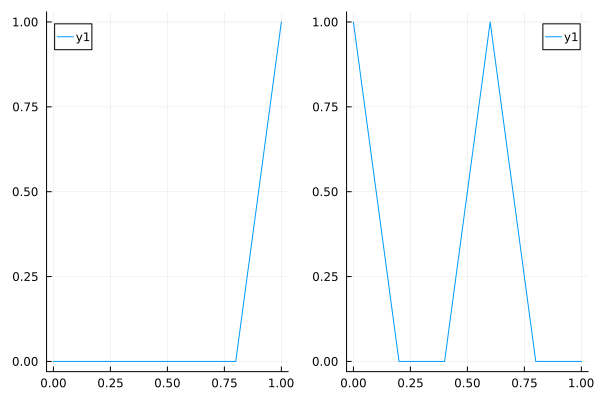

In [14]:
# generate basis function centered on node i 
function basisfct(x, xmesh, i)
    Np1 = length(xmesh)
    left = 0.
    right = 0.  
    if (i==1)
        right_domain = (x>=xmesh[i])*(x<=xmesh[i+1])
        right_value = (x-xmesh[i+1])/(xmesh[i]-xmesh[i+1])
        right = right_value*right_domain        
    end 
    if ((i>1)&&(i<Np1))
        left_domain = (x>=xmesh[i-1])*(x<=xmesh[i])
        left_value = (xmesh[i-1]-x)/(xmesh[i-1]-xmesh[i])
        left = left_value*left_domain        
        right_domain = (x>xmesh[i])*(x<=xmesh[i+1])
        right_value = (x-xmesh[i+1])/(xmesh[i]-xmesh[i+1])
        right = right_value*right_domain        
    end 
    if (i==Np1)
        left_domain = (x>=xmesh[i-1])*(x<=xmesh[i])
        left_value = (xmesh[i-1]-x)/(xmesh[i-1]-xmesh[i])
        left = left_value*left_domain
    end 
    result = left+right
    return result 
end 

# generate the mesh with N elements and Np1 nodes 
N = 5; h = 1/N; Np1 = N+1; 
xmesh = Vector(0:h:1)

# generate plots 
xsampled = Vector(0:h/10:1);
p1 = plot(xsampled,basisfct.(xsampled,Ref(xmesh),6))
p2 = plot(xsampled,basisfct.(xsampled,Ref(xmesh),1) + (1)*basisfct.(xsampled,Ref(xmesh),4))
plot(p1,p2,layout=(1,2))

### Section 2.5: Expand Magnetization in Basis of Hat Functions

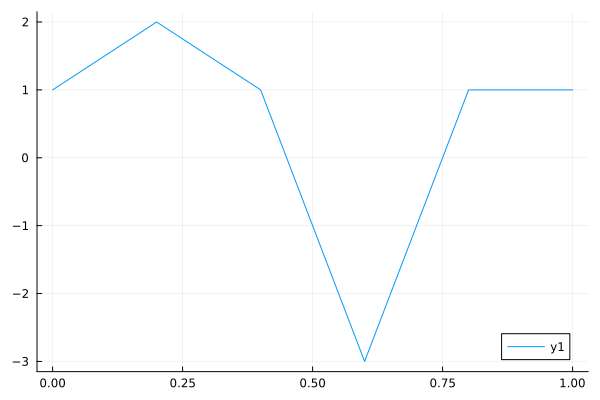

In [15]:
function magnetization(x,m,xmesh)
    Np1 = length(xmesh)
    result = 0. 
    for i=1:Np1 
        result += m[i]*basisfct(x,xmesh,i)
    end 
    return result  
end 

# generate the mesh with N elements and Np1 nodes 
N = 5; h = 1/N; Np1 = N+1; 
xmesh = Vector(0:h:1)
xsampled = Vector(0:h/2:1)

# generate plots 
m = ones(length(xmesh)) 
m[2] = 2; m[4] = -3; 
magnsampled = magnetization.(xsampled,Ref(m),Ref(xmesh))
plot(xsampled,magnsampled)
#display(magnsampled)

## Section 5: Explicit (or Direct) Construction - Assume Magnetic Sources Known - Compute Magnetic Vector Potential A_y and Magnetic Flux B_z 
Here we assume that the magnetization is a given block profile. We compute the vector potential component and the magnetic flux component. Results in this section can be verified by solving the one-dimensional Poisson equation for the scalar magnetic vector potential ($\phi_m$ such that $\vec{H} = \nabla \phi_m$). This can easily be accomplished using a shooting method for the boundary value problem. Such a shooting method is implemented in DifferentialEquations.jl. See the EE4375 course for example. 

### Section 1.5: Assume $M_z(x) = 1$ between $x=0.4$ and $x=0.6$: First Alternative 
This construction fails as quadgk is unable to treat the singular kernel without guidance. 

In [16]:
# define two input integrand
a = 0.4; b = 0.6; 
magnetization(x) = ((x>a)*(x<b))
kernel(x,xp) = (x-xp)/abs(x - xp)^3
vpdens(x,xp) = magnetization(xp)*kernel(x,xp)

# compute integral by quadrature over second input 
# observe the integration bounds 
vp(x) = quadgk(xp -> vpdens(x,xp), 0, 1)

# compute flux as x-derivative of potential  
bflux(x) = ForwardDiff.derivative(x -> vp(x)[1])

# generate plot 
N = 100; h = 1/N; 
xs = Vector(0:h:1)
ms = magnetization.(xs)
vps = vp.(xs)
bfluxs = bflux.(xs)

p1 = plot(xs, ms)
p2 = plot(xs, vps)
p3 = plot(xs, bfluxs)
plot(p1,p2,p3,layout=(1,3))

LoadError: DomainError with 0.4499999999999993:
integrand produced NaN in the interval (0.44999999999999574, 0.45000000000000284)

### Section 2.5: Assume $M_z(x) = 1$ between $x=0.4$ and $x=0.6$: Second Alternative
Remark: results in this section are <b>very</b> sensitive to the kernel definition. Here we use as kernel definition 
$$ K(x,x') = \frac{x-x'}{|x-x'|^{1.5}} $$
(observe the exponent 1.5 in the denominatior) for the lousy argumemt that anything else does not work (at least yet). 

Guide quadgk in performing integration of singular kernel by divide-and-conquer. We apply a mesh on the interval $\Omega = (0,1)$, perform integration on each element on the mesh and evaluate the integral on the nodes of the mesh. In this way we ensure that <b>singularity of integrand is always on the boundary of the integration domain</b>. 

We proceed in two steps. In the first step, we evaluate the vector potential component as a sum of contributions per element 

$A_y(x) = \frac{\mu_0}{4 \pi} \int_0^1 \frac{M_z(x') \, (x-x')}{|x-x'|^{1.5}} \, dx' 
        = \frac{\mu_0}{4 \pi} \sum_{k=1}^{N} \int_{x_k}^{x_{k+1}} \frac{M_z(x') \, (x-x')}{|x-x'|^{1.5}} \, dx' \, . $
        
This component is a function of $x$. In the second step, we evaluate $A_y(x)$ in the nodes of the mesh. 

In [45]:
# generate the mesh with N elements (intervals) and N+1 nodes 
N = 99; h = 1/N; Np1 = N+1; 
# N = 1000; h = 1/N; Np1 = N+1; 
xmesh = Vector(0:h:1)

# define two input integrand
a = 0.4; b = 0.6; 
#a = 0.; b = 1.; 
magnetization(x) = ((x>=a)*(x<=b)) 
kernel(x,xp) = (x-xp)/abs(x - xp)^1.5 # works and yield nice plot 
vpdens(x,xp) = magnetization(xp)*kernel(x,xp)
 
vparray = Array{Function}(undef, N)
# compute integral by quadrature over second input over all elements [x_k, x_{k+1}]
# observe syntax used to define an array of functions 
for k=1:N
    vparray[k] = x -> quadgk(xp -> vpdens(x,xp), xmesh[k], xmesh[k+1])[1]
end 

bfluxarray = Array{Function}(undef, N)
# compute bflux as x-derivative over all elements of vparray 
# observe syntax used to define an array of functions 
for k=1:N
  bfluxarray[k] = x -> ForwardDiff.derivative(x -> vparray[k](x)[1],x)
end 

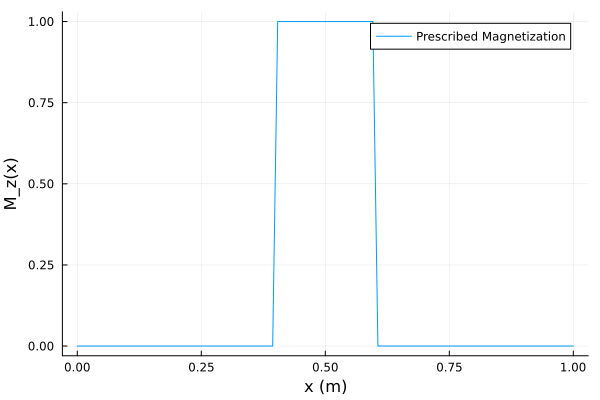

In [46]:
plot(xmesh, magnetization.(xmesh),xaxis="x (m)",yaxis="M_z(x)",label="Prescribed Magnetization")

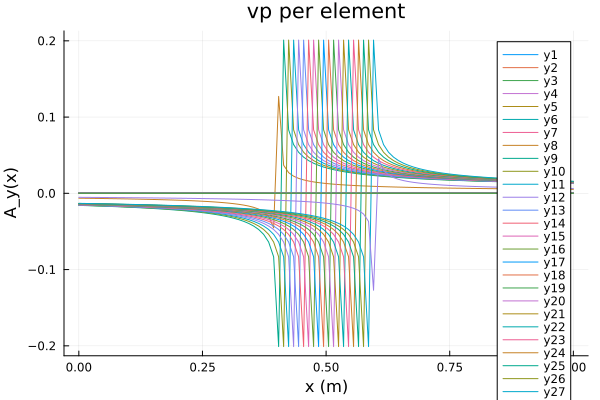

In [47]:
plot(xmesh,[vparray[k].(xmesh) for k=1:N],xaxis="x (m)",yaxis="A_y(x)",title="vp per element")

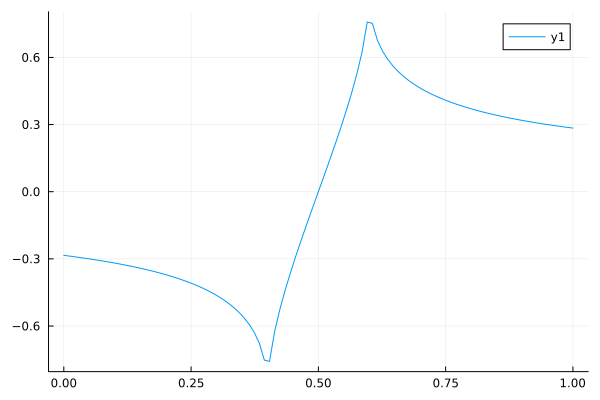

In [48]:
# evaluate vector potential as sum of contribution over N elements 
vparrayvec = sum([vparray[k].(xmesh) for k=1:N],dims=1)
plot(xmesh,vparrayvec)

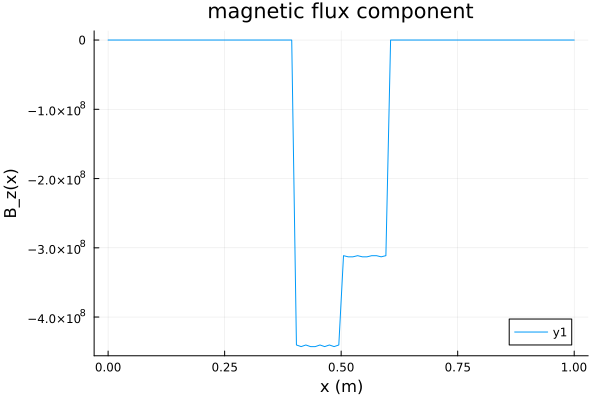

In [21]:
bfluxarrayvec = sum([bfluxarray[k].(xmesh) for k=1:N],dims=1)
plot(xmesh,bfluxarrayvec,xaxis="x (m)",yaxis="B_z(x)",title="magnetic flux component")

### Section 3.5: Magnitization Expanded in a Basis 

In [22]:
function magnetization(x,m,xmesh)
    Np1 = length(xmesh)
    result = 0. 
    for i=1:Np1 
        result += m[i]*basisfct(x,xmesh,i)
    end 
    return result  
end 

magnetization (generic function with 2 methods)

In [23]:
# generate the mesh  with N elements (intervals) and N+1 nodes
N = 100; h = 1/N; Np1 = N+1; 
xmesh = Vector(0:h:1)

# set the magnetization coefficients  
m = zeros(length(xmesh)) 
for i=div(N,4):3*div(N,4) m[i] = 1. end 

# define two input integrand
kernel(x,xp) = (x-xp)/abs(x - xp)^1.5
vpdens(x,xp,m,xmesh) = magnetization(xp,m,xmesh)*kernel(x,xp)
 
vparray = Array{Function}(undef, N)
# compute integral by quadrature over second input over all elements [x_k, x_{k+1}]
# observe syntax used to define an array of functions 
for k=1:N
   vparray[k] = (x,m,xmesh) -> quadgk(xp -> vpdens(x,xp,m,xmesh), xmesh[k], xmesh[k+1])[1]
end 

bfluxarray = Array{Function}(undef, N)
# compute bflux as x-derivative over all elements of vparray 
# observe syntax used to define an array of functions 
for k=1:N
  bfluxarray[k] = (x,m,xmesh) -> ForwardDiff.derivative(x -> vparray[k](x,m,xmesh)[1],x)
end 

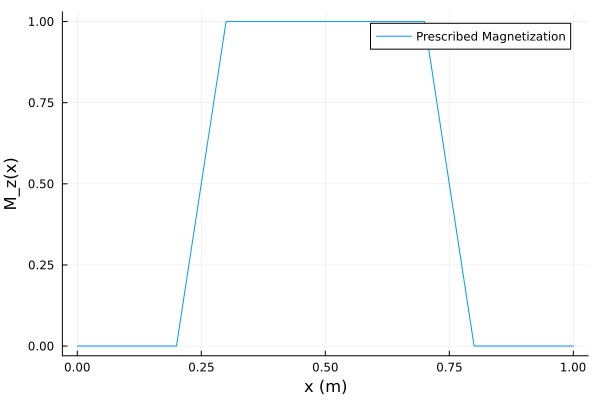

In [24]:
magnsampled = magnetization.(xsampled,Ref(m),Ref(xmesh))
plot(xsampled,magnsampled,xaxis="x (m)",yaxis="M_z(x)",label="Prescribed Magnetization")

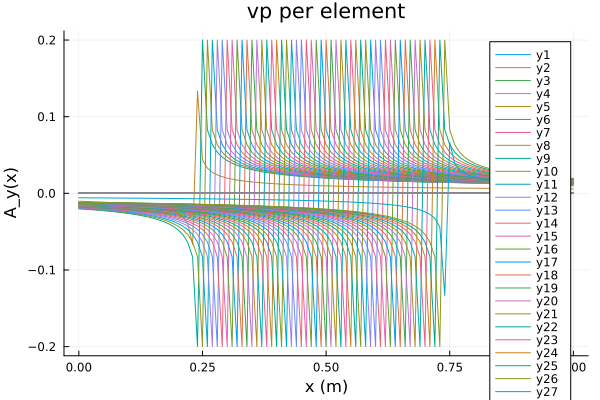

In [25]:
plot(xmesh,[vparray[k].(xmesh,Ref(m),Ref(xmesh)) for k=1:N],xaxis="x (m)",yaxis="A_y(x)",title="vp per element")

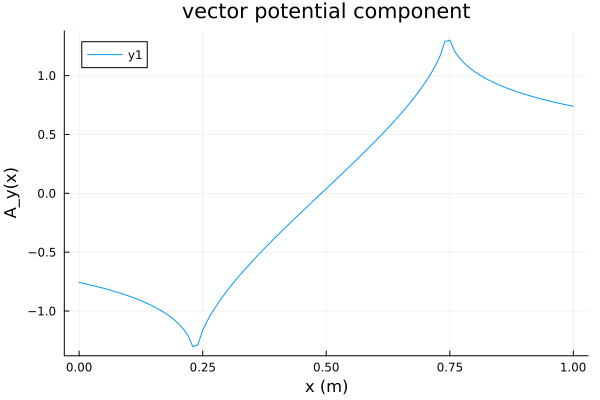

In [26]:
# evaluate vector potential as sum of contribution over N elements 
vparrayvec = sum([vparray[k].(xmesh,Ref(m),Ref(xmesh)) for k=1:N],dims=1)
plot(xmesh,vparrayvec,xaxis="x (m)",yaxis="A_y(x)",title="vector potential component")

In [36]:
vparray[1](xmesh[1],m[1],xmesh[1])

LoadError: BoundsError

In [35]:
bfluxarray[1](xmesh[1],m[1],xmesh[1])

LoadError: BoundsError

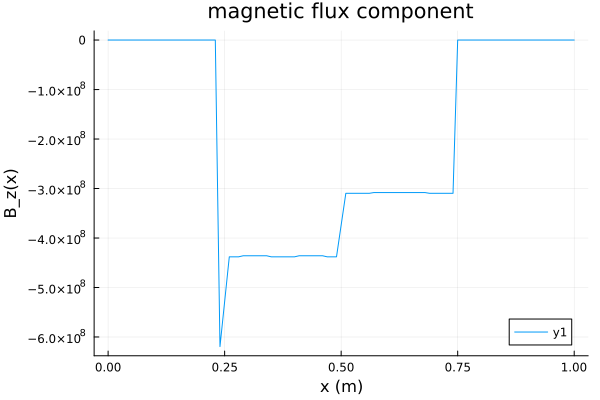

In [27]:
# evaluate magnetic flux as sum of contribution over N elements
bfluxarrayvec = sum([bfluxarray[k].(xmesh,Ref(m),Ref(xmesh)) for k=1:N],dims=1)
plot(xmesh,bfluxarrayvec,xaxis="x (m)",yaxis="B_z(x)",title="magnetic flux component")

## Section 6: Implicit Construction: Magnetic Source Unknown - Vector Potential and Magnetic Flux Defined in Terms of Expansion of Numerical Approximation to Magnetization 

In [28]:
mm = ones(size(xmesh));

In [29]:
methods(bfluxarray[1])

# 1 method for anonymous function "#43":
[1] (::var"#43#45")(x, m, xmesh) in Main at In[23]:24

In [30]:
bfluxarray[1](0.1,0.1,0.1)

LoadError: BoundsError

In [282]:
function bfluxarrayvec(m)
    results = zeros(size(m))
    N = length(m)-1 
    for k=1:N 
       results +=  
    end 
    return result
    
sum([bfluxarray[k].(xmesh,m,xmesh) for k=1:N],dims=1)

bfluxarrayvec2 (generic function with 1 method)

In [283]:
bfluxarrayvec2(mm)

LoadError: MethodError: no method matching (::var"#497#499"{Int64})(::Float64, ::Float64, ::Float64)
[0mClosest candidates are:
[0m  (::var"#497#499")(::Any) at In[256]:24

In [274]:
[bfluxarray[1](xi,mm,xi) for xi in xmesh]

LoadError: MethodError: no method matching (::var"#497#499"{Int64})(::Float64, ::Vector{Float64}, ::Float64)
[0mClosest candidates are:
[0m  (::var"#497#499")(::Any) at In[256]:24

In [269]:
bfluxsamp(m) = sum([bfluxarray[k](xi,m,xi) for xi in xmesh for k=1:N])

bfluxsamp (generic function with 1 method)

In [270]:
# compute the Jacobian  
mm = ones(size(xmesh))
bfluxsamp(mm)
##ForwardDiff.jacobian(bfluxsamp, mm) 

LoadError: MethodError: no method matching (::var"#497#499"{Int64})(::Float64, ::Vector{Float64}, ::Float64)
[0mClosest candidates are:
[0m  (::var"#497#499")(::Any) at In[256]:24

## Section 7: Memory Allocation for Automatic Differentiation of Jacobian 

In [ ]:
M = @SVector([10.0, 0.0, 0.0])
r = Vector([2.0, 1.0, 0.0]) 
y = Vector([0., 0., 0.])

function f!(y, r, M)
    y[1] = M * r[3]/norm(r)
    y[2] = M * r[1]/norm(r)
    y[3] = M * r[2]/norm(r)
end

function curl_of_function(f!, r)
    out=zeros(3)
    
    config = ForwardDiff.JacobianConfig(f!, out, r, ForwardDiff.Chunk{3}())
    Jac = Matrix{Float64}(undef, length(out), length(r))

    ForwardDiff.jacobian!(Jac, f!, out, r, config)
    curl_x = Jac[3,2] - Jac[2,3]
    curl_y = Jac[1,3] - Jac[3,1]
    curl_z = Jac[2,1] - Jac[1,2]
    return @SVector[curl_x, curl_y, curl_z]
end

@btime curl_of_function(f!, [2.0, 1.0, 0.0])

In [ ]:
y

In [ ]:
f!(y,r,M)

In [ ]:
function f(x,y,z, r)
    r_prime = [x,y,z]
    #r_prime = [x,y,z]
    return (r - r_prime)/norm(r - r_prime)
end

In [ ]:
g(x,y,r) = quadgk(z -> f(x, y, z, r), 0, 1)[1]
h(x, r) = quadgk(y -> g(x, y, r), 0, 1)[1]
l(r) =  quadgk(x -> h(x, r), 0, 1)[1]

In [ ]:
function curl_of_integral(f, r)

    out=zeros(3)
    
    config = ForwardDiff.JacobianConfig(l_wrapper!, out, r, ForwardDiff.Chunk{1}())
    Jac = Matrix{Float64}(undef, length(out), length(r))
    
    @btime ForwardDiff.jacobian!(l_wrapper!, r, $config)
    
    curl_x = Jac[3,2] - Jac[2,3]
    curl_y = Jac[1,3] - Jac[3,1]
    curl_z = Jac[2,1] - Jac[1,2]
    
    return [curl_x, curl_y, curl_z]
end     

In [ ]:
curl_of_integral(f, [2.0, 1.0, 0.0])